## Analisis de sentimiento

Bebido al confinamiento social producido por la pandemia del Covid-19, muchas personas migraron su entretenimiento a las plataformas de streaming. El aumento de visitas y reproducciones de estas páginas han generado gran cantidad de comentarios por parte de los consumidores, de manera que analizar estos datos no estructurados para extraer información importante se vuelve cada vez más difícil. Por tal motivo, en este trabajo se propone analizar los comentarios y determinar si tiene sentimientos negativos o positivos sobre el producto en sí. Para analizar sentimientos en texto se emplearán tres algoritmos, con el propósito de compararlos y determinar qué modelo es mejor para realizar la clasificación de sentimientos. Los modelos que se utilizaron es regresión logística y SVM como modelos tradiciones, los cuales se encogieron por su fácil implementación y a su vez brinda alto porcentaje de exactitud. Como tercer modelo se usa LSTM, por su capacidad en memoria de largo plazo. Durante todo el desarrollo del trabajo primero se prepararán los datos después, se aplicó ingeniería de características y por último, se entrenaron los algoritmo para probarlos y comparar su rendimiento. Como resultado se obtuvo que los algoritmos tradicionales varían su rendimiento según el modelo de vectorización de palabras que se aplique, y en este caso, se usó Bag of Words y TF-IDF como modelos para experimentación

### Preprocesamiento de los datos

Para lograr implementar cualquier modelo con éxito y resolver un problema, es importante realizar un preprocesamiento a los datos que se vayan a usar. Este proceso siempre se debe emplear porque los datos pueden estar sucios, contener ruido, datos faltantes, caracteres especiales, signos de puntuación, entre otras, los cuales no permitirán que el modelo sea entrenado correctamente. Por tal motivo, a continuación se efectúa el proceso de verificación, limpieza, transformación y división del conjunto para entrenamiento y pruebas

In [37]:
#Cargar librerias
import pandas as pd
import numpy as np
import nltk 
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re,string,unicodedata

from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split


#Modelos
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import LinearSVC

#LSTM
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')


El conjunto de datos que utilizara para el proceso de análisis de sentimientos en reseñas de películas, está conformado por 50 mil datos. El conjunto de datos está constituido por dos columnas (review, sentiment). Para cargar los datos, se utiliza la librería Pandas y se muestra los 10 primeros datos que contiene el datset. La columna review contiene información con datos sucios y ruidos.

In [2]:
#Muestra los 10 primeros review
data=pd.read_csv('IMDB Dataset.csv')
print(data.shape)
data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
#Imprime el review que se encuentra en la posición 4 
data['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

### Verificar datos

Una vez cargados los datos se verifica que el dataset no contenga valores nulos. Y para esto, se utiliza la función isnull para la comprobación. Esta función devolverá "True" si encuentra componentes faltantes y "False" para los componentes que no faltan. Finalmente, se contará todos los valores "True" y como se puede observar, el conteo dio 0, es decir, no existe valores nulos en todo el dataset.

In [4]:
#Se verifica si existe valores nullos en el dataset
data.isnull().sum()

review       0
sentiment    0
dtype: int64

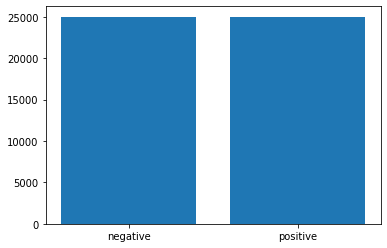

In [5]:
classes = data.sentiment.unique()
counts = []

for i in classes:
  count = len(data[data.sentiment==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

### Tokenizar

La tokenización sirve para encontrar y comprender patrones en el texto, el cual es útil para realizar el proceso de análisis de sentimiento. Este proceso es base para derivación y lematización del texto. Por tal motivo, en la siguiente línea de código se emplea el token y se configura las palabras vacías en el idioma en inglés.

In [6]:
#Tokenización de texto
tokenizer=ToktokTokenizer()

#Configuración de palabras vacías en inglés
stopword_list=nltk.corpus.stopwords.words('english')

### Eliminar etiquetas html y ruido en el texto

En las siguientes líneas de código se realiza el proceso de limpieza de los datos. Se desarrolla una función para eliminar cualquier elemento HTML que exista en los review. Otra función para eliminar expresiones regulares, como lo son corchetes, llaves, asteriscos, comillas, entre otros. También se elimina texto ruidoso y finalmente, la eliminación de caracteres especiales.

In [7]:
#Eliminar etiquetas de HTML
def etiqueta_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Eliminar algunas expresiones
def eliminar_corchetes(text):
    return re.sub('\[[^]]*\]', '', text)

#Elimina texto ruidoso
def eliminar_ruido(text):
    text = etiqueta_html(text)
    text = eliminar_corchetes(text)
    return text

#Aplicar la función denoise_text en la columna de review
data['review']=data['review'].apply(eliminar_ruido)

### Eliminación de caracteres especiales 

In [8]:
#Definir función para eliminar caracteres especiales
def eliminar_caracteres_especiales(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Aplicar la función remove_special_characters en la columna review
data['review']=data['review'].apply(eliminar_caracteres_especiales)

### Stemming

La implementación del Stemming se encarga de reducir las palabras a su raíz. Y es útil para asignar varias palabras a una palabra base en específico, esto no solo se hace con palabras, sino también con oraciones. Por tal motivo, en la siguiente línea de código se emplea Steamming en el texto.

In [9]:
#Stemming del texto
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Aplicar la función en la columna review 
data['review']=data['review'].apply(simple_stemmer)

### Eliminar palabras vacías

Con el proceso de tokenización, se desarrolla una función que elimina todas las palabras vacias y se aplica el metodo en la columna review.

In [10]:
#establecer palabras vacías en inglés
stop=set(stopwords.words('english'))

#eliminando las palabras vacías
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Aplicar la función
data['review']=data['review'].apply(remove_stopwords)

### Normalización de los review

Una vez terminado el proceso de limpieza de los datos, se emplea la normalización, es decir, estandariza todos los datos a un solo nive (palabras en minusculas)

In [11]:
#normalized train reviews
norm_train_reviews=data.review[:35000]

#Normalized test reviews
norm_test_reviews=data.review[35000:]

### Modelo Bags of words

Para realizar análisis de sentimiento se necesita crear una bolsa de palabras. El modelo Bag of Words es utilizado para representar los datos de prueba. Este método es empleado para PLN y IR. Para implementar este modelo se genera un vector de bolsas de palabras y después se hace un ajuste de los datos.

In [12]:
#Vectorizar para armar bolsa de palabras
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

#Transformar datos
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews) 

print('Ajuste de los datos de entrenamiento:',cv_train_reviews.shape)
print('Ajuste de los datos de prueba:',cv_test_reviews.shape)


Ajuste de los datos de entrenamiento: (35000, 5533754)
Ajuste de los datos de prueba: (15000, 5533754)


### Modelo TF-IDF

In [13]:
#Vectorizar Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

#Transformar datos y hacer fit
tv_train_reviews=tv.fit_transform(norm_train_reviews)

#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)

print('Ajuste de los datos de entrenamiento::',tv_train_reviews.shape)
print('Ajuste de los datos de prueba:',tv_test_reviews.shape)

Ajuste de los datos de entrenamiento:: (35000, 5533754)
Ajuste de los datos de prueba: (15000, 5533754)


### Transformación del etiquetado a datos binarios

Una vez ya procesado los datos pertenecientes a la columna review, ahora solo falta la columna sentiment. En el caso de este dataset, la columna sentiment únicamente tiene dos valores: positive, negative. Y como tal, estos valores se los pueden convertir en números binarios, en donde el 0 representa a los negativos y el 1 a los positivos. La función LabelBinariser hace este proceso de binarización.

In [14]:
#Función para convertir en binarios
lb=LabelBinarizer()

#transformación de los datos 
data['sentiment']=lb.fit_transform(data['sentiment'])

print(data['sentiment'].shape)

(50000,)


### Dividir el conjunto de las Y.

In [15]:
train_sentiments=data['sentiment'][:35000]
test_sentiments=data['sentiment'][35000:]

In [16]:
#Se exporta el nuevo dataset limpio. 
#ruta = "review_limpios.csv"
#data.to_csv(ruta)
data.head()

,review,sentiment
0,one review ha mention watch 1 oz episod youll ...,1
1,wonder littl product film techniqu veri unassu...,1
2,thought thi wa wonder way spend time hot summe...,1
3,basic famili littl boy jake think zombi hi clo...,0
4,petter mattei love time money visual stun film...,1


## Experimentación

### Word cloud para palabras positivas y negativas

En esta sección se presentan los resultados de la experimentación, en donde primero se realiza un análisis de las palabras que son mencionadas con más frecuencia en todas las reseñas etiquetadas como positivas. La nube de palabra muestra que las palabras más mencionadas son: movie, this, like, film, show, hi, entre otras más. Y las palabras más mencionadas en las reseñas etiquetadas como negativas son: this, film, movi, one, even entre otras 

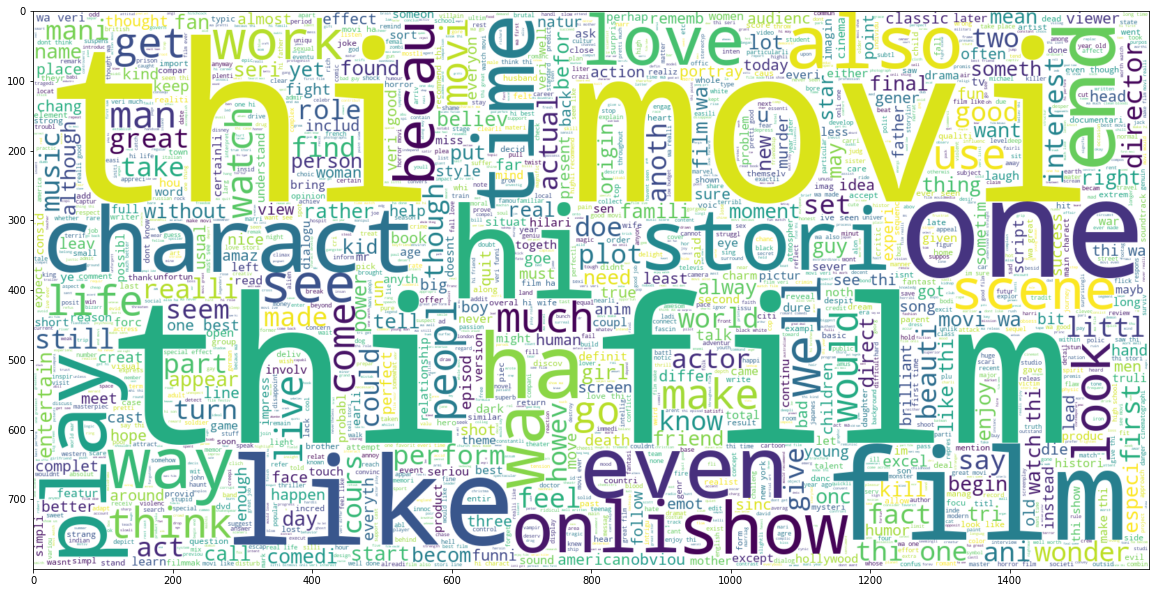

In [17]:
#word cloud para palabras positivas
plt.figure(figsize = (20,20))
wrdcld = WordCloud(max_words=2000,width=1600, height =800,
                   stopwords = stop,background_color='white').generate("".join(data[data['sentiment']==1].review))
plt.imshow(wrdcld,interpolation = 'bilinear')

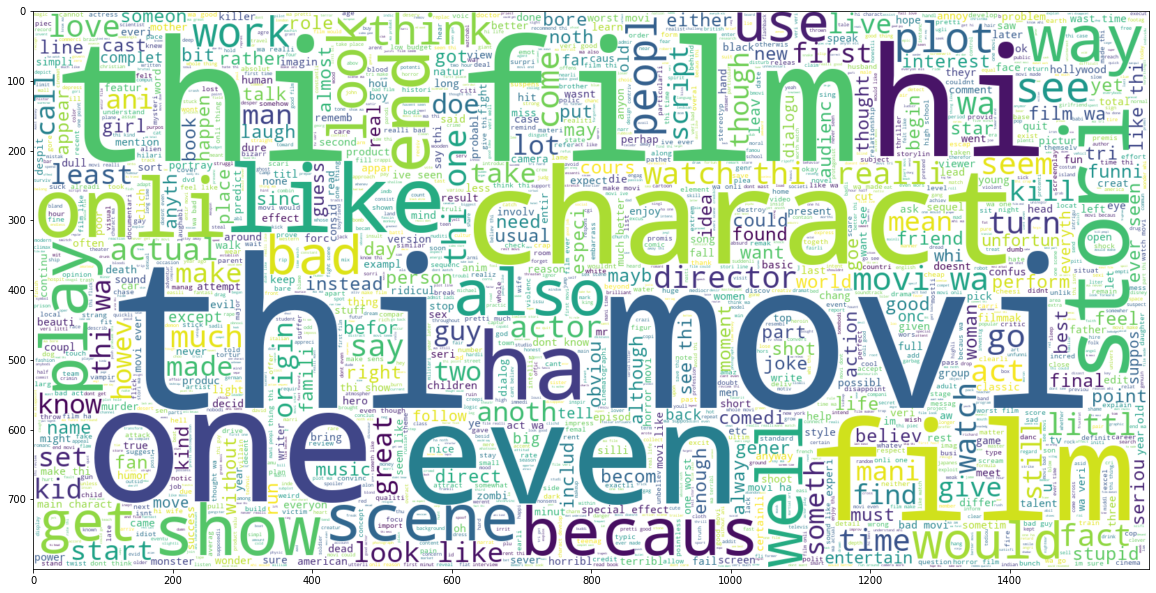

In [18]:
#word cloud para palabras negativas
plt.figure(figsize = (20,20))
wrdcld = WordCloud(max_words=2000,width=1600, height =800,
                   stopwords = stop,background_color='white').generate("".join(data[data['sentiment']==0].review))
plt.imshow(wrdcld,interpolation = 'bilinear')

## Regresión Logitica

Regresión logística es un método empleado en el análisis estadístico, el cual es encargado de predecir resultados que sean binarios, por ejemplo, si o no. El modelo logra predecir una variable que sea dependiente, por medio de su análisis realizado en las relaciones encontradas entre una o muchas variables independientes. Este modelo es usado con frecuencia en el análisis predictivo, el modelado, hasta llegar a extenderse a programas que se basan en aprendizaje automático.

Para la configuración se usan cuatro hiperparámetros los cuales son: penalty con valor de l2 para evitar el sobreajuste del modelo; max_iter es otro parámetro que se define para controlar el máximo de interacciones que se necesitan para que el solucionador converja. Con referencia al solucionador, como no se especifica con los parámetros, el modelo tomara el solucionador liblinear por defecto.  El valor de C, determinada la regularización del algoritmo, y por último está el parámetro random-state, el cual es usado para mezclar datos 

In [19]:
#Declara el modelo
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

#Ajusta el modelo para Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)

#Ajusta el modelo para tfidf 
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


### Predición del modelo con los datos de prueba 

In [20]:
#Predición del modelo para bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)

#Predición del modelo para tfidf 
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


### Acurrin del modelo 

In [21]:
#Accuracy score para bag of words
lr_bow_score=round((accuracy_score(test_sentiments, lr_bow_predict)*100), 2)
print("Accuracy de regresión con Bags of words: " , lr_bow_score , " %")

#lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
#print("lr_bow_score :",lr_bow_score)

#Accuracy score para tfidf features
lr_tfidf_score = round((accuracy_score(test_sentiments, lr_tfidf_predict)*100), 2)
print("Accuracy de regresión con TF-IDF: " , lr_tfidf_score , " %")

#lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
#print("lr_tfidf_score :",lr_tfidf_score)

Accuracy de regresión con Bags of words:  74.05  %
Accuracy de regresión con TF-IDF:  74.17  %


### Informe de clasificación 

Se emplea regresión logística, usando la bolsa de palabra Bags of words y TF-IDF. Como resultado obtenido, se puede observar que aplicando la bolsa de palabras Bags of words se obtuvo 74% tanto en precisión, recall y F1-score en positivos y negativos. En cambio, con TF-IDF el rendimiento del modelo vario.  

In [22]:
#Informe de clasificación para bag of words 
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

#Informe de clasificación para tfidf 
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.74      0.74      0.74      7490
    Negative       0.74      0.74      0.74      7510

    accuracy                           0.74     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.74      0.74      0.74     15000

              precision    recall  f1-score   support

    Positive       0.73      0.76      0.75      7490
    Negative       0.75      0.72      0.74      7510

    accuracy                           0.74     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.74      0.74      0.74     15000



## SVM

SVM es un algoritmo bastante utilizado para resolver problemas que requieren de regresión y clasificación. Este modelo puede solventar problemas lineales, así como también problemas que no son lineales. SVM se caracteriza por ser rápido de implementar y confiable, lo cual funciona bastante bien con cantidades limitadas de información para analizar. Su funcionamiento es imple de entender, porque se basa en crear un hiperplano o línea que divide los datos en dos conjuntos o clases.

En el caso del algoritmo de SVM, el primer parámetro que se debería escoger son los nucleas (kernel). Estos núcleos pueden varios, y los que comúnmente se usan son los: linear, poly, RBF y sigmoid. En el caso de que no se especifique el tipo de núcleo a utilizar, automáticamente el algoritmo utilizara RBF. Otro parámetro de SVM es la penalización, que viene siendo el valor de C, en donde estos números tienen que ser de tipo flotante, es decir, decimales. Al llegar al caso de que no se especifique el valor de C, se tomara el numero predeterminado que es 1.0. Para este modelo, en el trabajo simplemente se dejaron todos los valores predeterminados, porque en la experimentación se pudo observar que los valores predeterminados dan un mejor rendimiento 

In [23]:
#Declara el modelo SVM
svm = LinearSVC()

#Ajustar el modelo svm para bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)

#Ajustar el modelo svm para tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)


### Predición del modelo con los datos de prueba

In [24]:
#Predición del modelo para bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)

#Predición del modelo para tfidf features
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)


[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


### Accuracy del modelo SVM

In [25]:
#Accuracy score para bag of words
svm_bow_score=round((accuracy_score(test_sentiments, svm_bow_predict)*100), 2)
print("Accuracy de svm con Bags of words: " , svm_bow_score , " %")

#svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
#print("svm_bow_score :",svm_bow_score)

#Accuracy score para tfidf features
svm_tfidf_score=round((accuracy_score(test_sentiments, svm_tfidf_predict)*100), 2)
print("Accuracy de svm con TF-IDF: " , svm_tfidf_score, " %")

#svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
#print("svm_tfidf_score :",svm_tfidf_score)

Accuracy de svm con Bags of words:  74.03  %
Accuracy de svm con TF-IDF:  74.16  %


### Informe de clasificación

Con el uso de Bags of words da los mismos porcentajes que el algoritmo de Regresión Logística. También se puede notar que al igual que en regresión logística en TF-IDF el rendimiento del algoritmo SVM varia, teniendo los comentarios positivos valores mas altos que los negativos. A excepción de la precisión, porque los comentarios positivos tienen 72% y los negativos 76%. 

In [26]:
#Reporte de clasificación para bag of words 
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)

#Reporte de clasificación para tfidf features
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.74      0.74      0.74      7490
    Negative       0.74      0.74      0.74      7510

    accuracy                           0.74     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.74      0.74      0.74     15000

              precision    recall  f1-score   support

    Positive       0.72      0.78      0.75      7490
    Negative       0.76      0.70      0.73      7510

    accuracy                           0.74     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.74      0.74      0.74     15000



## LSTM

LSTM es un modelo perteneciente a las redes neuronales recurrentes (RNN). Este algoritmo se enfoca en los problemas que no pude resolver RNN. Por ejemplo, RNN no ofrece predicciones a palabras que se encuentran almacenadas a largo plazo, pero si da predicciones precisas con palabras que fueron almacenadas recientemente. EL algoritmo de LSTM almacena datos a largo plazo de manera predeterminada. Por lo tanto, LSTM es usado para predecir, procesar y clasificar sobre el conjunto de datos con series temporales 

Para la implementación de LSTM, primero se obtiene los 500 caracteres principales de cada reseña, para después seleccionar las 1000 palabras mas contadas. Una vez terminada toda la selección se emplea el desarrollo del modelo LSTM con capas de abandono para evitar el sobreajuste. Como resultado del entrenamiento y prueba de LSTM se obtuvieron buenos resultado, y sus valores de precisión, recall y F1-score son mas altos que los modelos tradicionales. Este resultado se debe porque el algoritmo LSTM tiene la capacidad de memorizar los datos a largo plazo y los utiliza para sacar conclusiones finales brindando mayor rendimiento al modelo. 

In [27]:
#Para explorar rápidamente el modelo LSTM, primero tomamos solo 500 caracteres.
#Esa es una forma mucho más rápida que tomar oraciones completas.
data['review_cleaned_500'] = data['review'].apply(lambda x:x[:500])
data['review_cleaned_500'][2]

'thought thi wa wonder way spend time hot summer weekend sit air condit theater watch lightheart comedi plot simplist dialogu witti charact likabl even well bread suspect serial killer may disappoint realiz thi match point 2 risk addict thought wa proof woodi allen still fulli control style mani us grown lovethi wa id laugh one woodi comedi year dare say decad ive never impress scarlet johanson thi manag tone sexi imag jump right averag spirit young womanthi may crown jewel hi career wa wittier d'

In [28]:
data.head()

,review,sentiment,review_cleaned_500
0,one review ha mention watch 1 oz episod youll ...,1,one review ha mention watch 1 oz episod youll ...
1,wonder littl product film techniqu veri unassu...,1,wonder littl product film techniqu veri unassu...
2,thought thi wa wonder way spend time hot summe...,1,thought thi wa wonder way spend time hot summe...
3,basic famili littl boy jake think zombi hi clo...,0,basic famili littl boy jake think zombi hi clo...
4,petter mattei love time money visual stun film...,1,petter mattei love time money visual stun film...


Convirtamos tokens en ID. Usaremos keras Tokenizer que puede filtrar puntuaciones y tomar solo las 10000 palabras más contadas.

In [29]:
tokenizer = Tokenizer(num_words=10000)

In [30]:
tokenizer.fit_on_texts(data['review_cleaned_500'])
seq = tokenizer.texts_to_sequences(data['review_cleaned_500'])
X = pad_sequences(seq, padding='post')
y = data['sentiment']
print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (50000, 109), X_min: 0, X_max: 9999


Construyamos el modelo LSTM simple utilizando los primeros conjuntos de datos de 500 caracteres.

In [31]:

#Se divide datos de entrenamiento y prueba del review500 mas importantes. 
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(32000, 109) (8000, 109) (10000, 109) (32000,) (8000,) (10000,)


Para LSTM, se definición el modelo sequential_2 para poder agregar varias capas y hacer una pila secuencial entre las capas y así aumentar el acurracy. Las capas que se agregaron fueron cuatro, las cuales son: capa de incrustación para convertir a los números de enteros positivos en vectores denso con un tamaño fijo; la capa de SpatialDropout1D, es una versión 1D de una capa de abandono normal, esta versión se encarga de descartar mapas de características 1D completos en lugar de elementos individuales. También está la capa de LSTM, que se encarga de establecer la memoria a largo plazo en donde se declara 64 bloques, y de último se encuentra una capa densa para realizar operaciones de matriz-vector, haciendo uso de la función de activación sigmoid. Para poder entrenar el modelo se utiliza el optimizador Adam. 

In [32]:
#Se desarrolla el modelo LSTM pero con capas de abandono para evitar el sobreajuste.
embed_size = 64
model_v2 = keras.models.Sequential([
    keras.layers.Embedding(input_dim=10000, output_dim=embed_size, input_shape=[None], mask_zero=True),
    #capa de abandono.
    keras.layers.SpatialDropout1D(0.2),
    keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    #capa de activación 
    keras.layers.Dense(1, activation='sigmoid')
])
model_v2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 64)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [33]:
#Entrenamiento del modelo
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
#capa de optimización
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#La red esta entrenando a 20 epocas y utiliza el tramaño de lote de 64
history = model_v2.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])


Epoch 1/20
500/500 [==============================] - 86s 156ms/step - loss: 0.5871 - accuracy: 0.6747 - val_loss: 0.4336 - val_accuracy: 0.8170
Epoch 2/20
500/500 [==============================] - 75s 150ms/step - loss: 0.3846 - accuracy: 0.8392 - val_loss: 0.3659 - val_accuracy: 0.8472
Epoch 3/20
500/500 [==============================] - 75s 149ms/step - loss: 0.3235 - accuracy: 0.8703 - val_loss: 0.3556 - val_accuracy: 0.8497
Epoch 4/20
500/500 [==============================] - 76s 152ms/step - loss: 0.2911 - accuracy: 0.8835 - val_loss: 0.3442 - val_accuracy: 0.8506
Epoch 5/20
500/500 [==============================] - 77s 153ms/step - loss: 0.2694 - accuracy: 0.8943 - val_loss: 0.3507 - val_accuracy: 0.8482
Epoch 6/20
500/500 [==============================] - 76s 152ms/step - loss: 0.2526 - accuracy: 0.9026 - val_loss: 0.3554 - val_accuracy: 0.8486
Epoch 7/20
500/500 [==============================] - 76s 153ms/step - loss: 0.2365 - accuracy: 0.9096 - val_loss: 0.3611 - val_ac

In [34]:
#Reporte de clasificación
y_pred= (model_v2.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

lstm_acurracy=round((accuracy_score(y_test, y_pred)*100), 2)
print("Accuracy de LSTM: " , lstm_acurracy, " %")

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Accuracy de LSTM:  85.22  %


#### Historial del accurancy 

En la grafica se muestra que el entrenamiento (accuracy) y la validación (val-accuracy) rondan entre el 80 y 85 %, en esta imagen se observa que la validación inicia con un incremento y se mantiene. El conjunto de entrenamiento en cambio se mantiene en incremento y tiene una diferencia del 5%. Por otro lado está la perdida (loss) y la validad de las perdidas(val-loss). En donde la perdida desciende y la validación tiene un ligero crecimiento. Estos resultados quieren decir que el modelo todavía le falta ser mejorado. 

<AxesSubplot:>

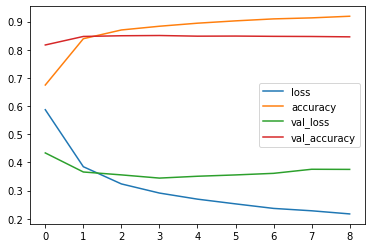

In [35]:
#Acurracy de entrenamiento
pd.DataFrame(history.history).plot()

#### Comparación

En la comparación se puede observar que la exactitud del modelo regresión logísticas y SVM son iguales, y a su vez menores que el modelo LSTM. Por lo tanto, se descarta el uso de regresión logísticas y SVM, para enforcarse mas en LSTM. Este algoritmo tubo mayor rendimientos porque consta de cuatro layes en total, en done una de ellas una capa de abandono para evitar un sobre ajuste del modelo. También, su capa de LSTM para la memoria a largo plazo permite retener el resultado del análisis obtenido en los primeros comentarios, para que en el análisis de los últimos comentarios sea más fácil de identificar si son positivos o negativos.

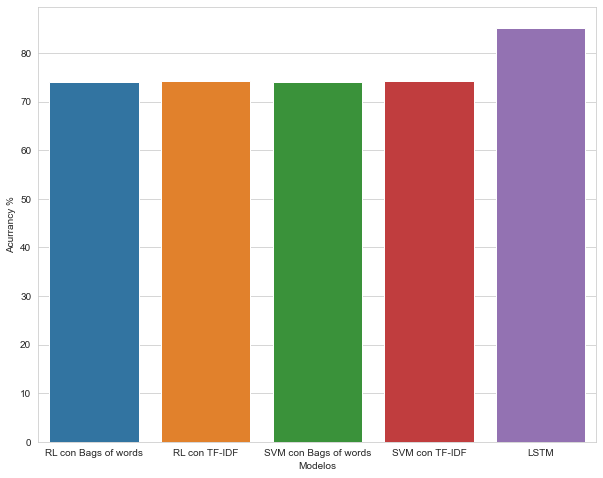

In [36]:
# Comparativa de los modelos. 

model = ['RL con Bags of words', 'RL con TF-IDF', 'SVM con Bags of words', 'SVM con TF-IDF', 'LSTM']
acc = [lr_bow_score ,lr_tfidf_score, svm_bow_score, svm_tfidf_score, lstm_acurracy]

sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Acurrancy %")
plt.xlabel("Modelos")
sns.barplot(x= model, y= acc)
plt.show()

Como conclusión sobre la experimentación realizada, se puede mencionar que el modelo Bag of Words permite crear vectores que contenga el recuento de palabras en una reseña, en cambio el modelo TF-IDF guarda las palabras más relevantes y las con menos importancia de igual forma. Los vectores creados por Bag of Words son fáciles de comprender, pero el modelo TF-IDF funciona mucho mejor en los algoritmos basado en aprendizaje automático. Por tal motivo, el uso de TF-IDF hace que los valores en precisión, recall y f1-scare de cada modelo varie. Sin embargo, se llaga a una misma exactitud. Esto no pasa con LSTM porque el algoritmo utiliza incrustaciones de keras para transformar el texto en números y así pode entrenar el modelo. 